In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Local imports
from qml.models.multiclass import HybridQuantumMultiClassCNN, BatchedGPUHybridQuantumMultiClassCNN

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# MNIST images are 28x28
IMAGE_SIZE = 28  
# Set to an int (e.g., 1000) for quick validation, None for full dataset
LIMIT_SAMPLES = None  

# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset_full = datasets.MNIST(root='../data/MNIST', train=True, download=True, transform=transform)
test_dataset_full = datasets.MNIST(root='../data/MNIST', train=False, download=True, transform=transform)

# Limit dataset size if specified
if LIMIT_SAMPLES is not None:
    train_dataset = Subset(train_dataset_full, range(min(LIMIT_SAMPLES, len(train_dataset_full))))
    test_dataset = Subset(test_dataset_full, range(min(LIMIT_SAMPLES // 5, len(test_dataset_full))))
else:
    train_dataset = train_dataset_full
    test_dataset = test_dataset_full

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Image shape: {train_dataset_full[0][0].shape}")
print(f"Number of classes: {len(train_dataset_full.classes)}")

Training images: 60000
Test images: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [4]:
# DataLoader configuration
BATCH_SIZE = 32

# Create data loaders from the pre-split datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

Train batches: 1875
Test batches: 313
Batch size: 32


## Create Quantum CNN Model

In [5]:
# Model configuration
from qml.ansatz.dense import DenseQCNNAnsatz4

# Select appropriate model class based on device
if device.type == 'cuda':
    print("Selecting BatchedGPUHybridQuantumMultiClassCNN for CUDA acceleration")
    ModelClass = BatchedGPUHybridQuantumMultiClassCNN
else:
    print("Selecting standard HybridQuantumMultiClassCNN")
    ModelClass = HybridQuantumMultiClassCNN

model = ModelClass(
    input_size=IMAGE_SIZE,
    num_classes=10,
    kernel_size=3,
    stride=1,
    encoding='dense',
    ansatz=DenseQCNNAnsatz4(),
    measurement='z',
    hidden_size=[64, 32]
)

model = model.to(device)

Selecting BatchedGPUHybridQuantumMultiClassCNN for CUDA acceleration
Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliZ
Using default.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliZ


## Setup Training

In [6]:
from notebooks.utils import print_model_parameters

# Display model parameter count
print_model_parameters(model)


MODEL PARAMETER COUNT
Total parameters:                45,768
Trainable parameters:            45,768
Non-trainable parameters:             0

Parameter breakdown by layer:
Layer                                    Parameters      Trainable 
-----------------------------------------------------------------
qconv.q_params                           30              Yes       
classical.1.weight                       43,264          Yes       
classical.1.bias                         64              Yes       
classical.4.weight                       2,048           Yes       
classical.4.bias                         32              Yes       
classical.7.weight                       320             Yes       
classical.7.bias                         10              Yes       


In [7]:
from notebooks.multiclass_trainer import MultiClassTrainer
from torch.optim.lr_scheduler import StepLR

# Training configuration
LEARNING_RATE = 0.002
EPOCHS = 20

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning Rate Scheduler
# StepLR decays the learning rate by gamma every step_size epochs
# Here: reduce LR by half every 5 epochs -> 0.002 -> 0.001 -> 0.0005 ...
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Create trainer
trainer = MultiClassTrainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [8]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader,
    scheduler=scheduler
)

Evaluating: 100%|██████████| 313/313 [04:59<00:00,  1.04it/s]  


Epoch 1: Train Loss=0.4865, Train Acc=0.8472 | Test Loss=0.1922, Test Acc=0.9402


Evaluating: 100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epoch 2: Train Loss=0.2580, Train Acc=0.9227 | Test Loss=0.1617, Test Acc=0.9486


Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 3: Train Loss=0.2177, Train Acc=0.9367 | Test Loss=0.1436, Test Acc=0.9560


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.87it/s]


Epoch 4: Train Loss=0.1925, Train Acc=0.9429 | Test Loss=0.1357, Test Acc=0.9585


Evaluating: 100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epoch 5: Train Loss=0.1781, Train Acc=0.9478 | Test Loss=0.1279, Test Acc=0.9614


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.85it/s]


Epoch 6: Train Loss=0.1457, Train Acc=0.9568 | Test Loss=0.1115, Test Acc=0.9663


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.86it/s]


Epoch 7: Train Loss=0.1344, Train Acc=0.9593 | Test Loss=0.1192, Test Acc=0.9632


Evaluating: 100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epoch 8: Train Loss=0.1331, Train Acc=0.9598 | Test Loss=0.1172, Test Acc=0.9656


Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 9: Train Loss=0.1240, Train Acc=0.9618 | Test Loss=0.1151, Test Acc=0.9651


Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 10: Train Loss=0.1172, Train Acc=0.9647 | Test Loss=0.1193, Test Acc=0.9667


Evaluating: 100%|██████████| 313/313 [01:51<00:00,  2.82it/s]


Epoch 11: Train Loss=0.1054, Train Acc=0.9672 | Test Loss=0.1149, Test Acc=0.9673


Evaluating: 100%|██████████| 313/313 [01:51<00:00,  2.80it/s]


Epoch 12: Train Loss=0.1022, Train Acc=0.9693 | Test Loss=0.1155, Test Acc=0.9668


Evaluating: 100%|██████████| 313/313 [01:51<00:00,  2.80it/s]


Epoch 13: Train Loss=0.0970, Train Acc=0.9706 | Test Loss=0.1158, Test Acc=0.9681


Evaluating: 100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epoch 14: Train Loss=0.0949, Train Acc=0.9709 | Test Loss=0.1167, Test Acc=0.9678


Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 15: Train Loss=0.0918, Train Acc=0.9715 | Test Loss=0.1207, Test Acc=0.9684


Evaluating: 100%|██████████| 313/313 [01:49<00:00,  2.86it/s]


Epoch 16: Train Loss=0.0867, Train Acc=0.9746 | Test Loss=0.1193, Test Acc=0.9693


Evaluating: 100%|██████████| 313/313 [01:52<00:00,  2.78it/s]


Epoch 17: Train Loss=0.0856, Train Acc=0.9735 | Test Loss=0.1177, Test Acc=0.9691


Evaluating: 100%|██████████| 313/313 [01:52<00:00,  2.79it/s]


Epoch 18: Train Loss=0.0845, Train Acc=0.9743 | Test Loss=0.1177, Test Acc=0.9689


Evaluating: 100%|██████████| 313/313 [01:50<00:00,  2.82it/s]


Epoch 19: Train Loss=0.0817, Train Acc=0.9753 | Test Loss=0.1193, Test Acc=0.9687


Evaluating: 100%|██████████| 313/313 [01:51<00:00,  2.80it/s]

Epoch 20: Train Loss=0.0782, Train Acc=0.9764 | Test Loss=0.1201, Test Acc=0.9704


## Train results

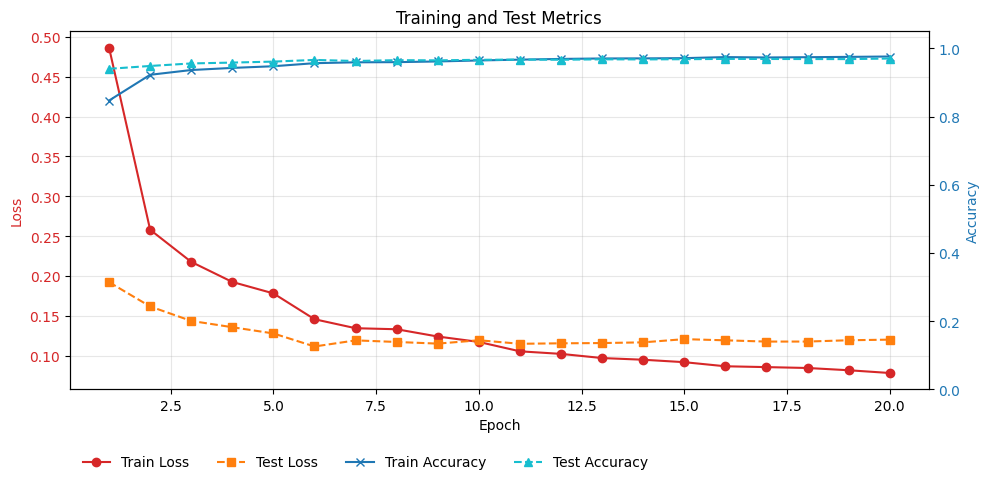

In [9]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 313/313 [01:51<00:00,  2.81it/s]



Final Test Results:
Test Loss: 0.1201
Test Accuracy: 0.9704


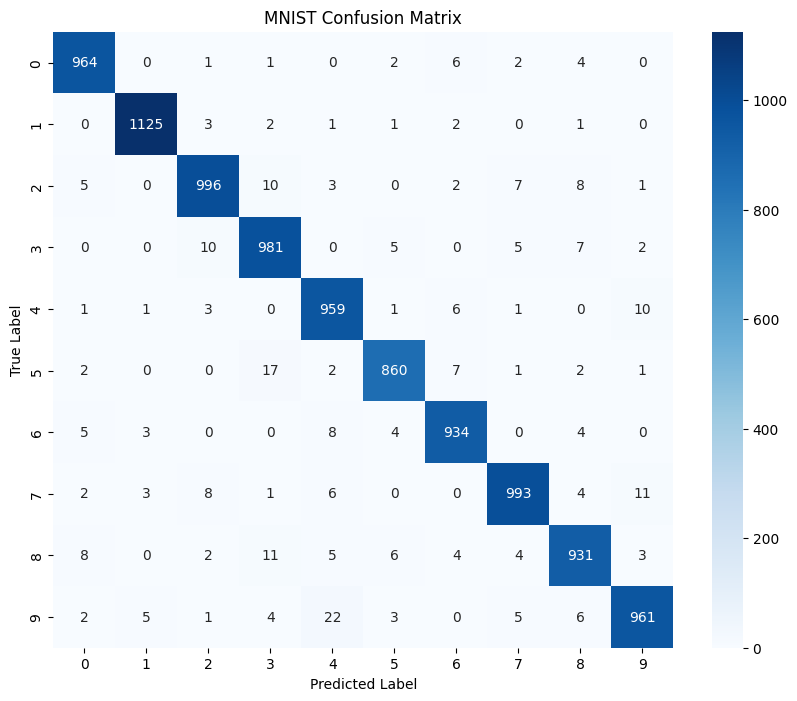


Per-Class Metrics:
Class    Precision    Recall       F1-Score    
------------------------------------------------
0        0.9747       0.9837       0.9792      
1        0.9894       0.9912       0.9903      
2        0.9727       0.9651       0.9689      
3        0.9552       0.9713       0.9632      
4        0.9533       0.9766       0.9648      
5        0.9751       0.9641       0.9696      
6        0.9719       0.9749       0.9734      
7        0.9754       0.9660       0.9707      
8        0.9628       0.9559       0.9593      
9        0.9717       0.9524       0.9620      

Overall Accuracy: 0.9704


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix for 10 classes
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('MNIST Confusion Matrix')
plt.show()

# Calculate per-class metrics
print(f"\nPer-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 48)

for i in range(10):
    tp = confusion_matrix[i, i]
    fp = confusion_matrix[:, i].sum() - tp
    fn = confusion_matrix[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{i:<8} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

# Overall metrics
total_correct = np.trace(confusion_matrix)
total_samples = confusion_matrix.sum()
print(f"\nOverall Accuracy: {total_correct / total_samples:.4f}")